In [4]:
from diskcache import Cache
import os
from Utils.data_manager import DataManager
from Utils.models import FLNet
from Clients.training import Training
import copy
import torch
from torch import nn
from Utils.analytics import Analytics
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
%load_ext autoreload
%autoreload 2
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class FULDebug:
    def __init__(self, cache, breakpoint, num_parties, num_fl_rounds):
        
        cache["breakpoint"] = breakpoint
        self.num_parties = num_parties
        self.num_fl_rounds = num_fl_rounds
        self.cache = cache
    
    def average_selected_models(self, selected_parties, party_models):
        with torch.no_grad():
            sum_vec = nn.utils.parameters_to_vector(party_models[selected_parties[0]].parameters())
            if len(selected_parties) > 1:
                for i in range(1,len(selected_parties)):
                    sum_vec += nn.utils.parameters_to_vector(party_models[selected_parties[i]].parameters())
                sum_vec /= len(selected_parties)

            model = copy.deepcopy(party_models[0])
            nn.utils.vector_to_parameters(sum_vec, model.parameters())
        return model.state_dict()
    
    def aggregate(self, client_models, current_model=None):
        selected_parties = [i for i in range(self.num_parties)]
        aggregated_model_state_dict = self.average_selected_models(selected_parties, client_models)
        return aggregated_model_state_dict 
    
    def partiesStart(self, trainloader_lst, testloader, client_to_be_erased=100, dataType="FMNIST"):

        num_fl_rounds = self.num_fl_rounds
        num_parties = self.num_parties
        initial_model = FLNet()
        model_dict = copy.deepcopy(initial_model.state_dict())
        for round_num in range(num_fl_rounds): 
            ##################### Local Training Round #############################
            current_model_state_dict = copy.deepcopy(model_dict)
            current_model = copy.deepcopy(initial_model)
            current_model.load_state_dict(current_model_state_dict)
            client_models = []
            party_losses = []
            for party_id in range(num_parties):

                if party_id == client_to_be_erased:
                    client_models.append(FLNet())
                else:
                    model = copy.deepcopy(current_model)
                    local_training = Training(num_updates_in_epoch=None, num_local_epochs=1)
                    model_update, party_loss = local_training.train(model=model, 
                                                trainloader=trainloader_lst[party_id], 
                                                criterion=None, opt=None, dataType=dataType)

                    client_models.append(copy.deepcopy(model_update))
                    party_losses.append(party_loss)
                    print(f"Party {party_id} Loss: {party_loss}")
            ######################################################################  
            current_model_state_dict = self.aggregate(client_models=client_models, current_model=current_model)
            model_dict = copy.deepcopy(current_model_state_dict)
            eval_model = FLNet()
            eval_model.load_state_dict(current_model_state_dict)
            clean_acc = local_training.evaluate(testloader, eval_model)
            # clean_accuracy[fusion_key][round_num] = clean_acc        
            self.cache[f"client_models"] = client_models
            self.cache[f"global_models"] = current_model_state_dict
            print(f'Global Clean Accuracy, round {round_num} = {clean_acc}')
            # print(self.cache.get(f"client_models_{round_num}"))

    # Function to compute class-wise accuracy
    def compute_classwise_metrics(self, model, test_loader):
        class_correct = defaultdict(int)
        class_total = defaultdict(int)
        
        model.eval()
        
        with torch.no_grad():
            for data, labels in test_loader:
                if data.dim() == 5:  # If the image has an extra dimension, squeeze it
                    data = data.squeeze(1)  # Remove the extra dimension
                    
                # Check if the input tensor has the correct shape for CIFAR-10
                if data.shape[1] == 32:  # Indicates the channel dimension is incorrectly set as 32
                    # Permute from [batch_size, height, width, channels] to [batch_size, channels, height, width]
                    data = data.permute(0, 3, 1, 2)
                    
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                
                # Update class-wise correct/total counts
                for label, prediction in zip(labels, predicted):
                    class_total[label.item()] += 1
                    if label.item() == prediction.item():
                        class_correct[label.item()] += 1
        
        # Compute class-wise accuracies
        class_accuracies = {cls: class_correct[cls] / class_total[cls] if class_total[cls] > 0 else 0
                            for cls in class_total}
        
        return class_accuracies, class_total

    # Function to identify classes impacted by unlearning
    def identify_affected_classes(self, global_model_before, global_model_after, test_loader, threshold=0.05):
        """
        Identify the classes that are significantly impacted after unlearning client 0.
        
        :param global_model_before: The global model before unlearning.
        :param global_model_after: The global model after unlearning.
        :param test_loader: The test data loader.
        :param threshold: The threshold to consider a class significantly impacted.
        :return: A list of impacted classes.
        """
        # Compute class-wise accuracy before and after unlearning
        before_class_accuracies, _ = self.compute_classwise_metrics(global_model_before, test_loader)
        after_class_accuracies, _ = self.compute_classwise_metrics(global_model_after, test_loader)
    
        impacted_classes = []
    
        # Compare class accuracies before and after unlearning
        for cls in before_class_accuracies:
            accuracy_drop = before_class_accuracies[cls] - after_class_accuracies[cls]
            if accuracy_drop > threshold:
                impacted_classes.append(cls)
    
        return impacted_classes

    def calculate_class_weights(self, global_model_before, global_model_after, test_loader, impacted_classes):
        """
        Calculate class weights based on the accuracy difference before and after unlearning.
        
        :param global_model_before: Global model before unlearning.
        :param global_model_after: Global model after unlearning.
        :param test_loader: DataLoader for the test data.
        :param impacted_classes: List of impacted classes.
        :return: Dictionary with class indices as keys and weights as values.
        """
        # Compute class-wise accuracies before and after unlearning
        class_accuracies_before, _ = self.compute_classwise_metrics(global_model_before, test_loader)
        class_accuracies_after, _ = self.compute_classwise_metrics(global_model_after, test_loader)
        
        # Calculate the absolute difference in accuracy for each impacted class
        accuracy_diffs = {class_idx: abs(class_accuracies_before[class_idx] - class_accuracies_after[class_idx])
                          for class_idx in impacted_classes}
        
        # Normalize the differences to sum to 1 (to be used as weights)
        total_diff = sum(accuracy_diffs.values())
        class_weights = {class_idx: (diff / total_diff) for class_idx, diff in accuracy_diffs.items()} if total_diff > 0 else {class_idx: 1/len(impacted_classes) for class_idx in impacted_classes}
        
        # Print class weights for reference
        for class_idx, weight in class_weights.items():
            print(f"Class {class_idx} Weight: {weight:.4f}")
        
        return class_weights

    
    def select_clients_to_fix_bias(self, clients_models, impacted_classes, test_loader, global_model, global_model_before, global_model_after, num_clients=3, lambda_penalty=0.1):
        """
        Select clients that contribute the most to the affected classes with automated class weighting and regularization.
        
        :param clients_models: List of models for remaining clients.
        :param impacted_classes: List of classes impacted by unlearning client 0.
        :param test_loader: DataLoader for the test data.
        :param global_model: Global model to compute deviations for regularization.
        :param global_model_before: Global model before unlearning.
        :param global_model_after: Global model after unlearning.
        :param num_clients: Number of clients to select for fixing the bias.
        :param lambda_penalty: Regularization term to penalize clients with large deviations from global performance.
        :return: Tuple of (list of selected client indices, list of selected client models).
        """
        # Automatically assign class weights based on accuracy impact
        class_weights = self.calculate_class_weights(global_model_before, global_model_after, test_loader, impacted_classes)
    
        client_contributions = []
        
        # Compute global model's class-wise accuracy for regularization
        global_class_accuracies, _ = self.compute_classwise_metrics(global_model, test_loader)
        
        # Compute class-wise accuracy for each client
        for client_idx, client_model in enumerate(clients_models):
            class_accuracies, _ = self.compute_classwise_metrics(client_model, test_loader)
            
            # Calculate the weighted contribution of this client to the impacted classes
            contribution = sum((class_accuracies[class_idx] * class_weights[class_idx]) for class_idx in impacted_classes)
            
            # Compute the regularization term: deviation from the global model
            deviation_penalty = sum(abs(class_accuracies[class_idx] - global_class_accuracies[class_idx]) for class_idx in impacted_classes)
            
            # Final score: contribution minus regularization penalty
            final_contribution = contribution - lambda_penalty * deviation_penalty
            
            client_contributions.append((client_idx, client_model, final_contribution))
        
        # Sort clients by their final contribution score
        client_contributions.sort(key=lambda x: x[2], reverse=True)
        
        # Select top clients to fix the bias
        selected_clients = client_contributions[:num_clients]
        
        # Extract client indices and models for the selected clients
        selected_client_indices = [client_idx for client_idx, _, _ in selected_clients]
        selected_client_models = [client_model for _, client_model, _ in selected_clients]
        
        # Print selected clients and their contributions
        for client_idx, _, contribution in selected_clients:
            print(f"Selected Client {client_idx} with Contribution: {contribution:.4f}")
        
        # Return both selected client indices and models
        return selected_client_models, selected_client_indices


    def unlearnedModelAggregationWithSelectedClients(self, trainloader_lst, testloader, unlearned_model, num_rounds=10, client_to_be_erased=100, select_clients_method='random', select_num_clients=6):
    
        num_parties = self.num_parties
        initial_model = FLNet()
        current_model_state_dict = copy.deepcopy(unlearned_model.state_dict())  
        initial_model.load_state_dict(current_model_state_dict)  
        model_dict = copy.deepcopy(initial_model.state_dict())

        model_before = self.cache.get('initial_model')
        model_before.load_state_dict(self.cache.get('global_models'))
        model_before.eval()
        
        model_after = self.cache.get('initial_model')
        model_after.load_state_dict(self.cache.get("unlearned_model").state_dict())
        model_after.eval()
        
        client_model = self.cache.get('initial_model')
        client_model.load_state_dict(self.cache.get("client_models")[0].state_dict())
        client_model.eval()
        
        global_model_accuracies = []
        for round_num in range(num_rounds): 
            ##################### Local Training Round #############################
            current_model_state_dict = copy.deepcopy(model_dict)
            current_model = copy.deepcopy(initial_model)
            current_model.load_state_dict(current_model_state_dict)
            client_models = []
            party_losses = []
    
            for party_id in range(num_parties):
                if party_id == client_to_be_erased:
                    client_models.append(FLNet())  # Placeholder for unlearned client
                else:
                    model = copy.deepcopy(current_model)
                    local_training = Training(num_updates_in_epoch=None, num_local_epochs=1)
                    model_update, party_loss = local_training.train(model=model, 
                                                    trainloader=trainloader_lst[party_id], 
                                                    criterion=None, opt=None, dataType="CIFAR")
    
                    client_models.append(copy.deepcopy(model_update))
                    party_losses.append(party_loss)
                    print(f"Party {party_id} Loss: {party_loss}")
    
            ###################### Client Selection ###############################
            impacted_classes = self.identify_affected_classes(model_before, model_after, testDataloader, threshold=0.05)
            selected_client_models, selected_client_indices = self.select_clients_to_fix_bias(client_models, impacted_classes, testDataloader, model_before, model_before, model_after, num_clients=5)
            print(selected_client_models)
    
            #######################################################################
            # Aggregate only the selected client models
            current_model_state_dict = self.unlearnAggregate(client_models=selected_client_models, client_to_be_erased=client_to_be_erased)
            model_dict = copy.deepcopy(current_model_state_dict)
            eval_model = FLNet()
            eval_model.load_state_dict(current_model_state_dict)
    
            clean_acc = local_training.evaluate(testloader, eval_model)
            print(f'Global Clean Accuracy, round {round_num} = {clean_acc}')
            global_model_accuracies.append(clean_acc)
            self.cache[f"unlearning_client_models_with_FULDebug"] = client_models
            self.cache[f"unlearning_global_models_with_FULDebug"] = current_model_state_dict
            model_after = self.cache.get('initial_model')
            model_after.load_state_dict(current_model_state_dict)
            model_after.eval()
        return global_model_accuracies
    
    def unlearnAggregate(self, client_models, client_to_be_erased):
        selected_parties = [i for i in range(len(client_models))]
        aggregated_model_state_dict = self.average_selected_models(selected_parties, client_models)
        return aggregated_model_state_dict
    
    def unlearnedModelAggregation(self, trainloader_lst, testloader, unlearned_model, num_rounds=10, client_to_be_erased=100):

        num_parties = self.num_parties
        initial_model = FLNet()
        current_model_state_dict = copy.deepcopy(unlearned_model.state_dict())  
        initial_model.load_state_dict(current_model_state_dict)  
        model_dict = copy.deepcopy(initial_model.state_dict())
        for round_num in range(num_rounds): 
            ##################### Local Training Round #############################
            current_model_state_dict = copy.deepcopy(model_dict)
            current_model = copy.deepcopy(initial_model)
            current_model.load_state_dict(current_model_state_dict)
            client_models = []
            party_losses = []
            for party_id in range(num_parties):

                if party_id == client_to_be_erased:
                    client_models.append(FLNet())
                else:
                    model = copy.deepcopy(current_model)
                    local_training = Training(num_updates_in_epoch=None, num_local_epochs=1)
                    model_update, party_loss = local_training.train(model=model, 
                                                trainloader=trainloader_lst[party_id], 
                                                criterion=None, opt=None, dataType="FMNIST")

                    client_models.append(copy.deepcopy(model_update))
                    party_losses.append(party_loss)
                    print(f"Party {party_id} Loss: {party_loss}")
            ######################################################################  
            current_model_state_dict = self.unlearnAggregate(client_models=client_models, client_to_be_erased=client_to_be_erased)
            model_dict = copy.deepcopy(current_model_state_dict)
            eval_model = FLNet()
            eval_model.load_state_dict(current_model_state_dict)
            clean_acc = local_training.evaluate(testloader, eval_model)
            # clean_accuracy[fusion_key][round_num] = clean_acc      
            self.cache[f"unlearning_client_models"] = client_models
            self.cache[f"unlearning_global_models"] = current_model_state_dict
            print(f'Global Clean Accuracy, round {round_num} = {clean_acc}')

    def compute_weight_contribution(self, global_model, client_updates, selected_client_idx):
        """
        Compute the influence of each client's weight contribution to the global model.

        :param global_model: The baseline global model (PyTorch model)
        :param client_updates: List of model updates from each client (list of state_dicts)
        :param selected_client_idx: Index of the client whose contribution you want to analyze
        :return: Difference between the global model's weights with and without the selected client's contribution
        """
        # Compute the average weight update with all clients
        num_clients = len(client_updates)
        avg_update = {key: torch.zeros_like(val) for key, val in client_updates[0].state_dict().items()}

        for update in client_updates:
            for key in update.state_dict():
                avg_update[key] += update.state_dict()[key] / num_clients

        # Compute the average weight update without the selected client
        avg_update_without_client = {key: torch.zeros_like(val) for key, val in client_updates[0].state_dict().items()}

        for i, update in enumerate(client_updates):
            if i == selected_client_idx:
                continue  # Skip the selected client
            for key in update.state_dict():
                avg_update_without_client[key] += update.state_dict()[key] / (num_clients - 1)

        # Calculate the difference in the global model's weights
        weight_difference = {key: avg_update[key] - avg_update_without_client[key] for key in avg_update}

        return weight_difference

    def compute_weight_norm_difference(self, weight_difference):
        """
        Computes the norm of the weight differences to quantify the impact.

        :param weight_difference: Dictionary containing weight differences for each layer
        :return: Dictionary with norms for each layer
        """
        norm_diff = {}
        for layer, diff in weight_difference.items():
            norm_diff[layer] = torch.norm(diff).item()
        return norm_diff
    
    def analyze_class_bias(self, global_model, weight_difference, num_classes=10):
        """
        Analyzes the class-specific impact of removing a client's weight contribution.

        :param global_model: The baseline global model (PyTorch model)
        :param weight_difference: Difference in weights with and without the selected client's contribution
        :param num_classes: Number of classes in the dataset (e.g., 10 for MNIST)
        :return: Impact on each class based on output layer weight differences
        """
        output_layer_key = None

        # Identify the output layer by checking for the appropriate layer name
        for key in weight_difference.keys():
            if 'weight' in key and weight_difference[key].shape[0] == num_classes:
                output_layer_key = key
                break

        if output_layer_key is None:
            raise ValueError("Could not identify the output layer in the model.")

        # Analyze the impact on each class
        class_impact = torch.norm(weight_difference[output_layer_key], dim=1).tolist()
        return class_impact

    def summarize_and_print_results(slef, norm_diff, class_impact):
        """
        Summarizes and prints the results of the weight differences and class impacts.

        :param norm_diff: Dictionary containing the norms of weight differences for each layer
        :param class_impact: List containing the impact on each class
        """
        print("=== Summary of Weight Differences by Layer ===")
        print(f"{'Layer':<20} {'Norm Difference':>20}")
        print("-" * 40)
        
        for layer, norm in norm_diff.items():
            print(f"{layer:<20} {norm:>20.6f}")
        
        print("\n=== Impact on Each Class ===")
        print(f"{'Class':<10} {'Impact':>10}")
        print("-" * 25)
        
        for class_idx, impact in enumerate(class_impact):
            print(f"Class {class_idx:<5} {impact:>10.6f}")
        
        print("\n=== Analysis ===")
        
        # Find the class with the maximum and minimum impact
        max_impact_class = max(range(len(class_impact)), key=lambda i: class_impact[i])
        min_impact_class = min(range(len(class_impact)), key=lambda i: class_impact[i])
        
        print(f"The highest impact is on Class {max_impact_class} with an impact value of {class_impact[max_impact_class]:.6f}.")
        print(f"The lowest impact is on Class {min_impact_class} with an impact value of {class_impact[min_impact_class]:.6f}.")

        # Determine which layers are most and least affected
        most_affected_layer = max(norm_diff, key=norm_diff.get)
        least_affected_layer = min(norm_diff, key=norm_diff.get)
        
        print(f"The most affected layer is '{most_affected_layer}' with a norm difference of {norm_diff[most_affected_layer]:.6f}.")
        print(f"The least affected layer is '{least_affected_layer}' with a norm difference of {norm_diff[least_affected_layer]:.6f}.")
        print("\nThis analysis suggests that removing the selected client's contribution mainly affects the above class and layer.")



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Initialize the cache
cache = Cache('./cache-ibmful10', size_limit=5 * 10**9)
initial_model = FLNet()
cache["initial_model"] = initial_model
breakpoint =  {"round": 5, "status": False}
# Initialize the MNIST loader
loader = DataManager(download_dir="./data", normalize=True)
# Load the MNIST data
(x_train, y_train), (x_test, y_test) = loader.load_mnist()
# dataLoader = loader.split_data_uneven(x_train, y_train)
# dataLoader = loader.split_data_label_flipping(x_train, y_train)
dataLoader = loader.split_data_dirichlet(x_train, y_train, alpha=4)
# dataLoader = loader.split_data_shards_rare_classes(x_train, y_train)
# dataLoader = loader.split_data_extreme_minority_two(x_train, y_train)
testDataloader = loader.get_test_dataloader(x_test, y_test)
print(testDataloader)

In [7]:
parties = 10
sim = FULDebug(cache, breakpoint, parties, 10)
sim.partiesStart(dataLoader, testDataloader)

Party 0 Loss: 1.6912471098559243
Party 1 Loss: 2.0139997164408365
Party 2 Loss: 1.782756268978119
Party 3 Loss: 1.9854155723438707
Party 4 Loss: 1.933793353099449
Party 5 Loss: 1.9734663297963697
Party 6 Loss: 1.9481532275676727
Party 7 Loss: 2.006196697552999
Party 8 Loss: 2.1036118462279036
Party 9 Loss: 1.6526373928668452
Global Clean Accuracy, round 0 = 77.27
Party 0 Loss: 0.6148491209106786
Party 1 Loss: 0.6598481039206187
Party 2 Loss: 0.6148028146136891
Party 3 Loss: 0.6510744864164397
Party 4 Loss: 0.6604638093826818
Party 5 Loss: 0.6425951199476109
Party 6 Loss: 0.6763115656375885
Party 7 Loss: 0.6647357827141172
Party 8 Loss: 0.6938086353443764
Party 9 Loss: 0.53148866547089
Global Clean Accuracy, round 1 = 90.54
Party 0 Loss: 0.33404614802982124
Party 1 Loss: 0.33555341495407953
Party 2 Loss: 0.33025104105472564
Party 3 Loss: 0.3241694469091504
Party 4 Loss: 0.328496259801528
Party 5 Loss: 0.3349987084782401
Party 6 Loss: 0.3476312527060509
Party 7 Loss: 0.3326383236618269
P

In [9]:
from Ful_Algo.ibm_ful import IBMFUL
%load_ext autoreload
%autoreload 2
# Usage example
unlearning_instance = IBMFUL(
    client_models=cache.get("client_models"),
    global_model=cache.get("global_models"),
    num_parties=10,  # Example value
    party_to_be_erased=0,  # Example value
    trainloader_lst=dataLoader,
    testloader=testDataloader,
    testloader_poison=dataLoader,
    initial_model=FLNet(),
    lr=0.01,
    num_local_epochs_unlearn=5,
    distance_threshold=0.1,
    clip_grad=5
)

unlearned_model = unlearning_instance.execute_unlearning()
cache["unlearned_model"] = unlearned_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mean distance of Reference Model to random: 442.76629638671875
Radius for model_ref: 147.58876037597656
------------ 0
Distance from the unlearned model to party to be erased: 0.0963723286986351
Distance from the unlearned model to party to be erased: 0.09718266874551773
Distance from the unlearned model to party to be erased: 0.0989057719707489
Distance from the unlearned model to party to be erased: 0.10266149044036865
Clean Accuracy for UN-Local Model = 95.51


In [10]:
sim = FULDebug(cache, breakpoint, parties, 10)
sim.unlearnedModelAggregation(dataLoader, testDataloader, unlearned_model, num_rounds=5, client_to_be_erased=0)

Party 1 Loss: 0.10300648460785548
Party 2 Loss: 0.11682240847836842
Party 3 Loss: 0.09943223805275074
Party 4 Loss: 0.10836992975251347
Party 5 Loss: 0.10609354780510415
Party 6 Loss: 0.11339013561606408
Party 7 Loss: 0.10212973017422926
Party 8 Loss: 0.09959307272691985
Party 9 Loss: 0.08987086500022926
Global Clean Accuracy, round 0 = 97.61
Party 1 Loss: 0.10887018773290846
Party 2 Loss: 0.11226721554994583
Party 3 Loss: 0.10805521372619063
Party 4 Loss: 0.11651214548185759
Party 5 Loss: 0.11437697058846784
Party 6 Loss: 0.11177454851567745
Party 7 Loss: 0.10448623262345791
Party 8 Loss: 0.11059911528954634
Party 9 Loss: 0.09811746369243837
Global Clean Accuracy, round 1 = 97.42
Party 1 Loss: 0.11890409348739518
Party 2 Loss: 0.1277708515524864
Party 3 Loss: 0.1232546497742797
Party 4 Loss: 0.12109346958059891
Party 5 Loss: 0.12335310581811638
Party 6 Loss: 0.1265523099899292
Party 7 Loss: 0.11442788069446881
Party 8 Loss: 0.11905112681356636
Party 9 Loss: 0.10482031055817417
Global 

In [11]:
sim = FULDebug(cache, breakpoint, parties, 10)
global_model_accuracies_with_FULDebug = sim.unlearnedModelAggregationWithSelectedClients(dataLoader, testDataloader, unlearned_model, num_rounds=5, client_to_be_erased=0)

Party 1 Loss: 0.10071546485026678
Party 2 Loss: 0.10691202475943348
Party 3 Loss: 0.10609843529934107
Party 4 Loss: 0.10789871299821957
Party 5 Loss: 0.11554647670235745
Party 6 Loss: 0.10577341340482235
Party 7 Loss: 0.10494564784069856
Party 8 Loss: 0.10035518496423154
Party 9 Loss: 0.08893672756704629
Class 4 Weight: 1.0000
Selected Client 7 with Contribution: 0.9855
Selected Client 9 with Contribution: 0.9837
Selected Client 5 with Contribution: 0.9810
Selected Client 1 with Contribution: 0.9791
Selected Client 8 with Contribution: 0.9791
[FLNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
), FLNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (

In [81]:
%load_ext autoreload
%autoreload 2

analytics = Analytics(cache)
analytics.client_vs_global_per_class_accuracy(0, testDataloader)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
### Client {client_idx} vs Global Model Per Class Accuracy ###
Client Model Accuracy = 67.99%, Global Model Before Accuracy = 91.70%
Class 0: Client Model Accuracy = 99.80%, Global Model Before Accuracy = 98.88%
Class 1: Client Model Accuracy = 96.92%, Global Model Before Accuracy = 98.06%
Class 2: Client Model Accuracy = 72.48%, Global Model Before Accuracy = 92.73%
Class 3: Client Model Accuracy = 0.00%, Global Model Before Accuracy = 83.07%
Class 4: Client Model Accuracy = 57.94%, Global Model Before Accuracy = 85.34%
Class 5: Client Model Accuracy = 96.52%, Global Model Before Accuracy = 90.25%
Class 6: Client Model Accuracy = 58.56%, Global Model Before Accuracy = 95.20%
Class 7: Client Model Accuracy = 73.74%, Global Model Before Accuracy = 82.78%
Class 8: Client Model Accuracy = 26.18%, Global Model Before Accuracy = 94.46%
Class 9: Client Model Accuracy = 96.04%, Global Model Before Accuracy

In [11]:
analytics.unlearned_model_vs_global_per_class_accuracy(testDataloader)

### Unlearned vs Global Model Per Class Accuracy ###
Unlearned Model Accuracy = 81.98%, Global Model Before Accuracy = 97.02%
Class 0: Global Model Before = 98.98%, After = 98.27%, Δ = -0.71%
Class 1: Global Model Before = 94.54%, After = 0.00%, Δ = -94.54%
Class 2: Global Model Before = 97.09%, After = 87.11%, Δ = -9.98%
Class 3: Global Model Before = 97.62%, After = 91.58%, Δ = -6.04%
Class 4: Global Model Before = 98.07%, After = 95.01%, Δ = -3.05%
Class 5: Global Model Before = 97.31%, After = 89.35%, Δ = -7.96%
Class 6: Global Model Before = 97.91%, After = 94.89%, Δ = -3.03%
Class 7: Global Model Before = 96.79%, After = 82.88%, Δ = -13.91%
Class 8: Global Model Before = 96.10%, After = 99.69%, Δ = 3.59%
Class 9: Global Model Before = 96.23%, After = 94.05%, Δ = -2.18%
######


In [12]:
analytics.global_before_vs_global_after_per_class_accuracy(testDataloader)


### Unlearned vs Global Model Per Class Accuracy ###
Global Model After Accuracy = 97.81%, Global Model Before Accuracy = 97.02%
Class 0: Global Model Before = 98.98%, After = 99.29%, Δ = 0.31%
Class 1: Global Model Before = 94.54%, After = 96.30%, Δ = 1.76%
Class 2: Global Model Before = 97.09%, After = 98.45%, Δ = 1.36%
Class 3: Global Model Before = 97.62%, After = 97.52%, Δ = -0.10%
Class 4: Global Model Before = 98.07%, After = 98.68%, Δ = 0.61%
Class 5: Global Model Before = 97.31%, After = 98.54%, Δ = 1.23%
Class 6: Global Model Before = 97.91%, After = 98.02%, Δ = 0.10%
Class 7: Global Model Before = 96.79%, After = 96.79%, Δ = 0.00%
Class 8: Global Model Before = 96.10%, After = 97.54%, Δ = 1.44%
Class 9: Global Model Before = 96.23%, After = 97.32%, Δ = 1.09%
######


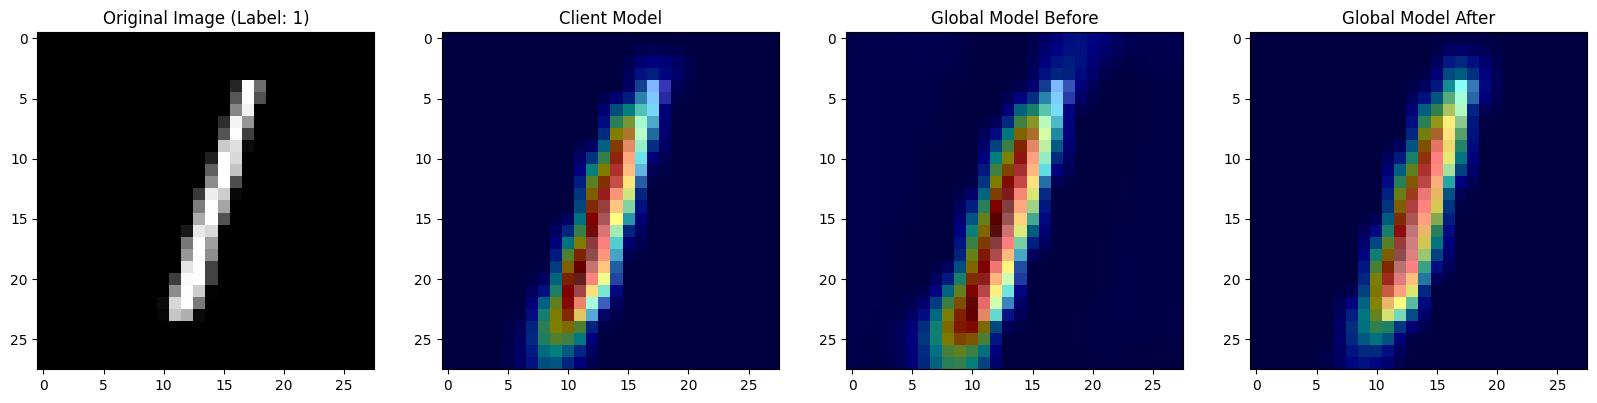

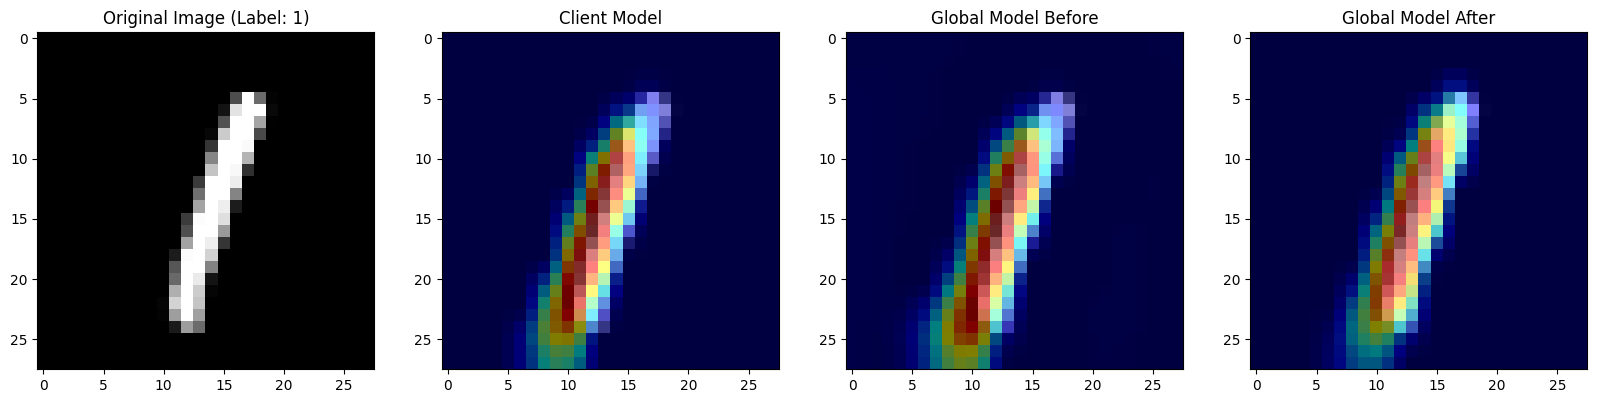

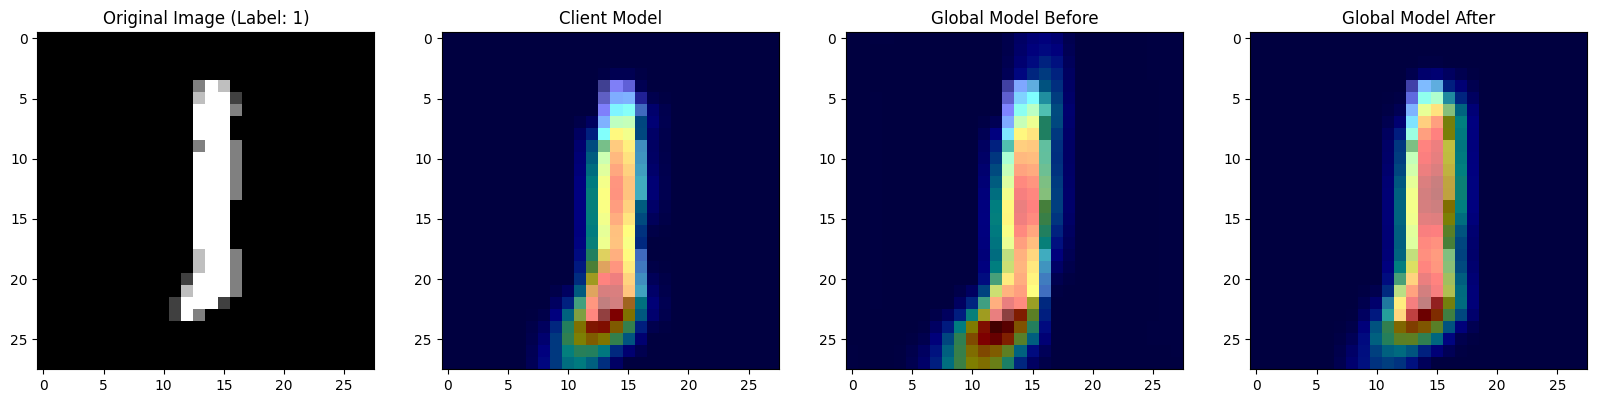

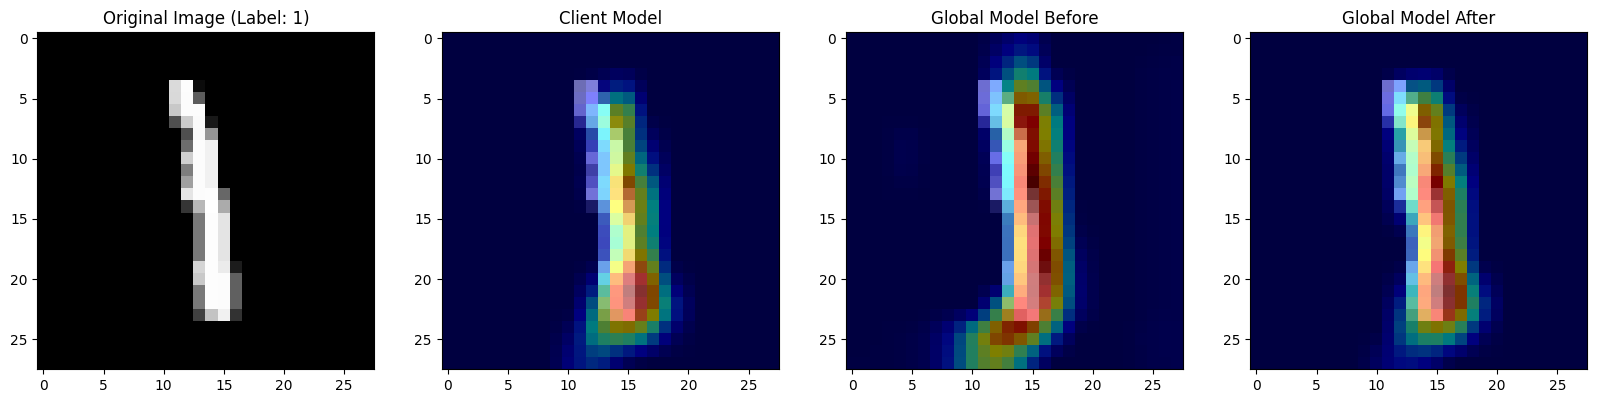

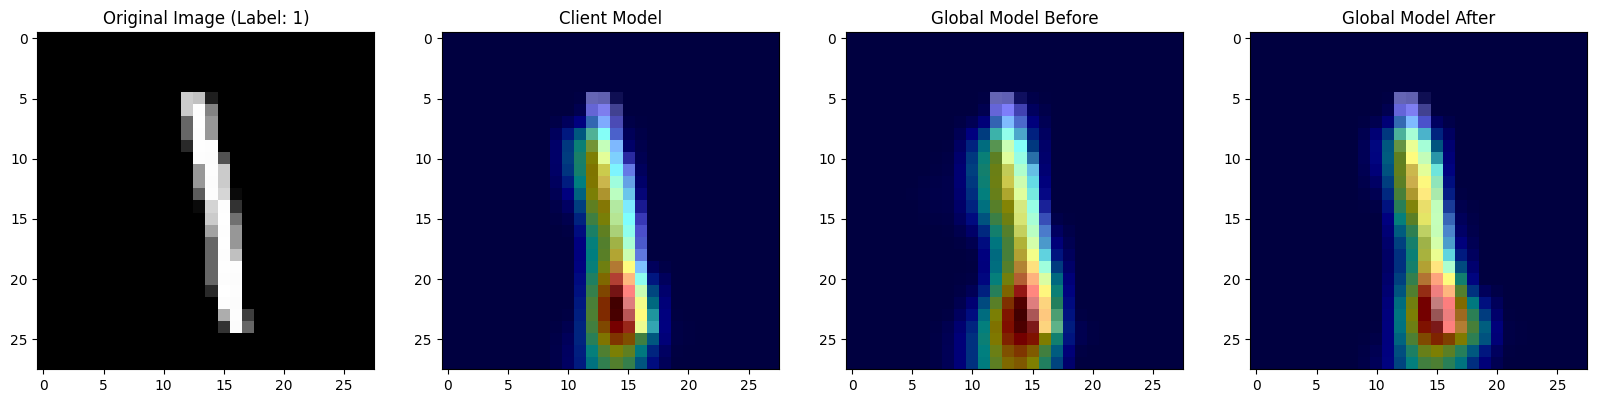

In [13]:
analytics.visualize_feature_comparison(client_idx=0, testDataloader=testDataloader, num_images_to_visualize=5, visualization_class=1)

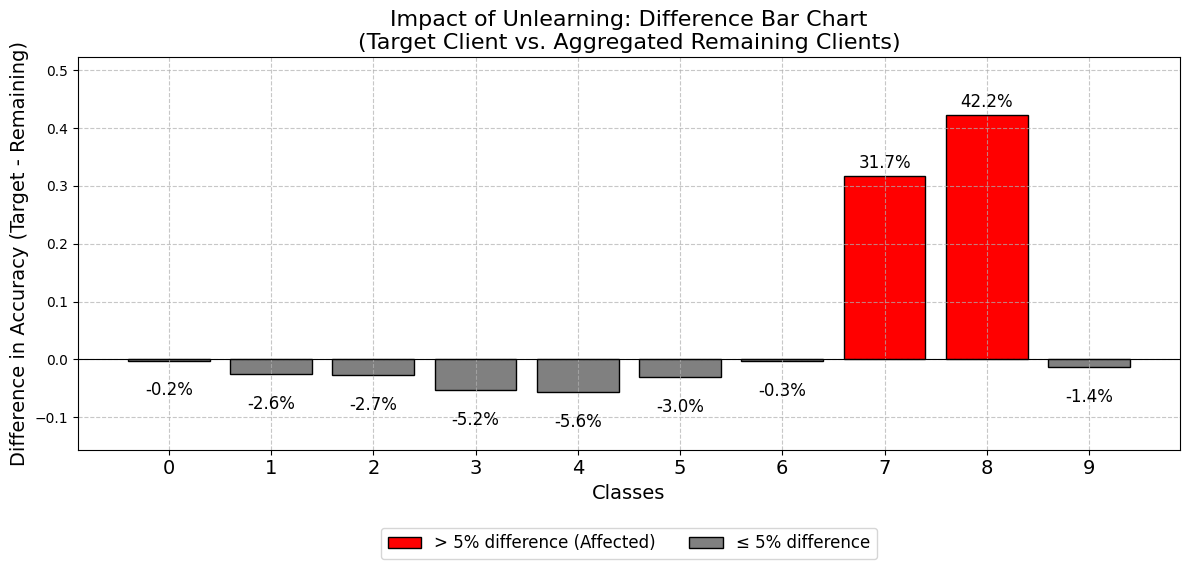

In [158]:
analytics.plot_client_unlearning_impact_bar(0, testDataloader)

In [15]:
analytics.display_feature_summary(0, testDataloader)


Class 0:
Client Model 0:                  |||||||||||||||||------------- (0.0111)
Global Model Before Unlearning:  ||||||||||||||||||||---------- (0.0129)
Global Model After Unlearning:   |||||||||||||||||||----------- (0.0123)

Class 1:
Client Model 0:                  |||||||||||||||--------------- (0.0098)
Global Model Before Unlearning:  ||||||||||||||---------------- (0.0093)
Global Model After Unlearning:   |||||||||||||||--------------- (0.0094)

Class 2:
Client Model 0:                  ||||||||||||||---------------- (0.0087)
Global Model Before Unlearning:  ||||||||||||||||-------------- (0.0101)
Global Model After Unlearning:   ||||||||||||||||||------------ (0.0113)

Class 3:
Client Model 0:                  ||||||||||||||||-------------- (0.0103)
Global Model Before Unlearning:  ||||||||||||||||||||---------- (0.0127)
Global Model After Unlearning:   ||||||||||||||||||||---------- (0.0129)

Class 4:
Client Model 0:                  |||||||||||||||||||||||||----- (0.0162)
G

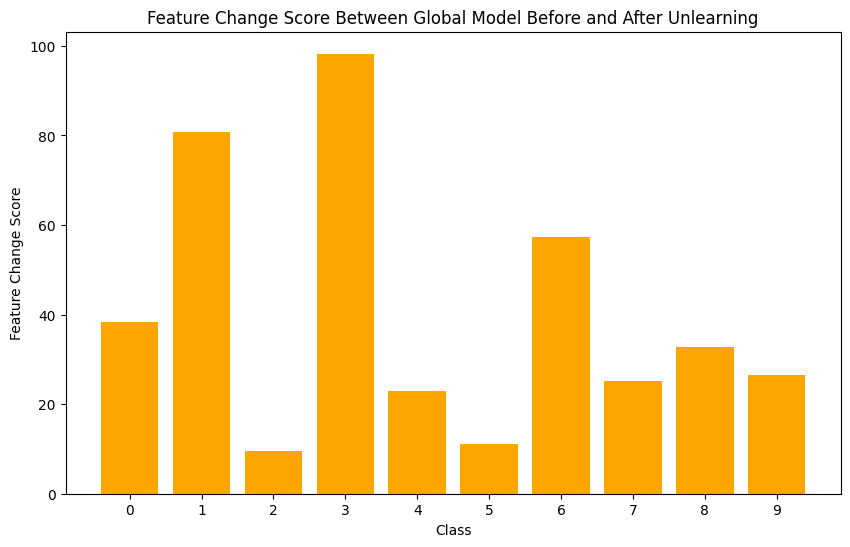

In [18]:
analytics.visualize_feature_change_class_wise_shared_unlearned_model(client_idx=0, testDataloader=testDataloader)

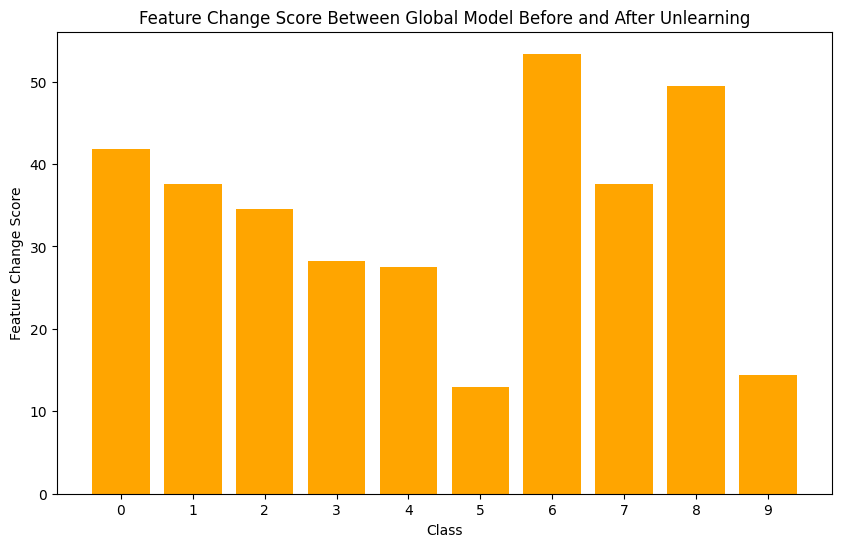

In [19]:
analytics.visualize_feature_change_class_wise(client_idx=0, testDataloader=testDataloader)

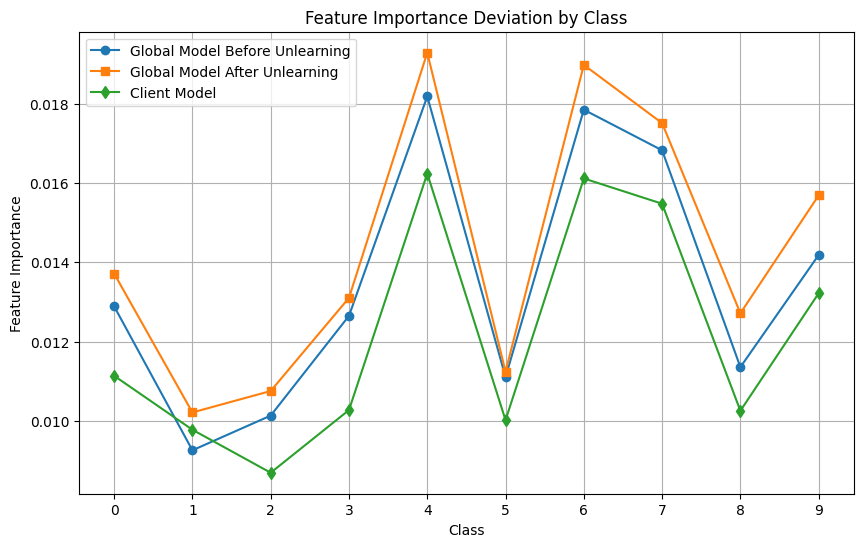

In [20]:
analytics.plot_mean_feature_deviation(client_idx=0, test_loader=testDataloader)

In [27]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from scipy.spatial.distance import cosine
from sklearn.metrics import mutual_info_score

# Define a function to compute cosine similarity between two sets of outputs
def cosine_similarity(outputs1, outputs2):
    return 1 - cosine(outputs1.flatten(), outputs2.flatten())

# Define a function to compute KL divergence between two sets of outputs
def kl_divergence(outputs1, outputs2):
    p = torch.softmax(outputs1, dim=1).numpy()
    q = torch.softmax(outputs2, dim=1).numpy()
    return np.sum(p * np.log(p / q))

# Define a function to compare model outputs
def compare_model_outputs(model1, model2, dataloader):
    similarities = []
    model1.eval()
    model2.eval()
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs1 = model1(images)
            outputs2 = model2(images)
            similarity = cosine_similarity(outputs1, outputs2)
            similarities.append(similarity)
    return np.mean(similarities)

# Example usage
if __name__ == "__main__":
    # Load models (replace with your actual models)
    model_before = cache.get('initial_model')
    model_before.load_state_dict(cache.get('global_models'))
    model_before.eval()
    
    model_after = cache.get('initial_model')
    model_after.load_state_dict(cache.get("unlearned_model").state_dict())
    model_after.eval()
    
    client_model = cache.get('initial_model')
    client_model.load_state_dict(cache.get("client_models")[9].state_dict())
    client_model.eval()

    # Load a common dataset (e.g., MNIST or Fashion-MNIST)
    common_dataset = testDataloader
    dataloader = common_dataset

    # Step 1: Compare global model (before unlearning) with client model
    similarity_before = compare_model_outputs(model_before, client_model, dataloader)
    print(f"Similarity before unlearning: {similarity_before:.4f}")

    # Step 2: Compare global model (after unlearning) with client model
    similarity_after = compare_model_outputs(model_after, client_model, dataloader)
    print(f"Similarity after unlearning: {similarity_after:.4f}")

    # Step 3: Evaluate unlearning
    if  similarity_before - similarity_after > 0.1:
        print("Unlearning was successful: The global model has diverged from the client model.")
    else:
        print("Unlearning may not be successful: The global model is still similar to the client model.")

Similarity before unlearning: 0.9909
Similarity after unlearning: 0.9494
Unlearning may not be successful: The global model is still similar to the client model.


In [31]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# Define a function to generate synthetic inputs
def generate_synthetic_inputs(num_samples, input_shape):
    """
    Generate random synthetic inputs.
    :param num_samples: Number of samples to generate.
    :param input_shape: Shape of each input sample (e.g., [1, 28, 28] for MNIST).
    :return: Synthetic inputs as a PyTorch tensor.
    """
    return torch.randn(num_samples, *input_shape)

# Define a function to generate a proxy dataset using the client's model
def build_proxy_dataset(client_model, num_samples=1000, input_shape=(1, 28, 28)):
    """
    Build a proxy dataset using the client's model.
    :param client_model: The client's model.
    :param num_samples: Number of samples in the proxy dataset.
    :param input_shape: Shape of each input sample.
    :return: A TensorDataset containing synthetic inputs and outputs.
    """
    # Generate synthetic inputs
    synthetic_inputs = generate_synthetic_inputs(num_samples, input_shape)
    
    # Use the client's model to generate outputs
    client_model.eval()
    with torch.no_grad():
        synthetic_outputs = client_model(synthetic_inputs)
    
    # Create a proxy dataset
    proxy_dataset = TensorDataset(synthetic_inputs, synthetic_outputs)
    return proxy_dataset

# Example usage
if __name__ == "__main__":
    # Load the client's model (replace with your actual model)
    model_before = cache.get('initial_model')
    model_before.load_state_dict(cache.get('global_models'))
    model_before.eval()
    
    model_after = cache.get('initial_model')
    model_after.load_state_dict(cache.get("unlearned_model").state_dict())
    model_after.eval()
    
    client_model = cache.get('initial_model')
    client_model.load_state_dict(cache.get("client_models")[5].state_dict())
    client_model.eval()

    # Build the proxy dataset
    proxy_dataset = build_proxy_dataset(client_model, num_samples=1000, input_shape=(1, 28, 28))

    # Use the proxy dataset for unlearning verification
    dataloader = DataLoader(proxy_dataset, batch_size=32, shuffle=False)

    # Compare model outputs on the proxy dataset
    def compare_model_outputs(model1, model2, dataloader):
        similarities = []
        model1.eval()
        model2.eval()
        with torch.no_grad():
            for inputs, _ in dataloader:
                outputs1 = model1(inputs)
                outputs2 = model2(inputs)
                similarity = 1 - cosine(outputs1.flatten(), outputs2.flatten())
                similarities.append(similarity)
        return np.mean(similarities)

    # Step 1: Compare global model (before unlearning) with client model on proxy dataset
    similarity_before = compare_model_outputs(model_before, client_model, dataloader)
    print(f"Similarity before unlearning: {similarity_before:.4f}")

    # Step 2: Compare global model (after unlearning) with client model on proxy dataset
    similarity_after = compare_model_outputs(model_after, client_model, dataloader)
    print(f"Similarity after unlearning: {similarity_after:.4f}")

    # Step 3: Evaluate unlearning
    if similarity_before - similarity_after > 0.15:
        print("Unlearning was successful: The global model has diverged from the client model on the proxy dataset.")
    else:
        print("Unlearning may not be successful: The global model is still similar to the client model on the proxy dataset.")

Similarity before unlearning: 0.9905
Similarity after unlearning: 0.9340
Unlearning may not be successful: The global model is still similar to the client model on the proxy dataset.


Global Model Before Unlearning Accuracy: 95.02%
Unlearned Model Accuracy: 81.27%
Unlearned Model Accuracy with FulDebug: 94.70%
Client Model Accuracy: 19.85%


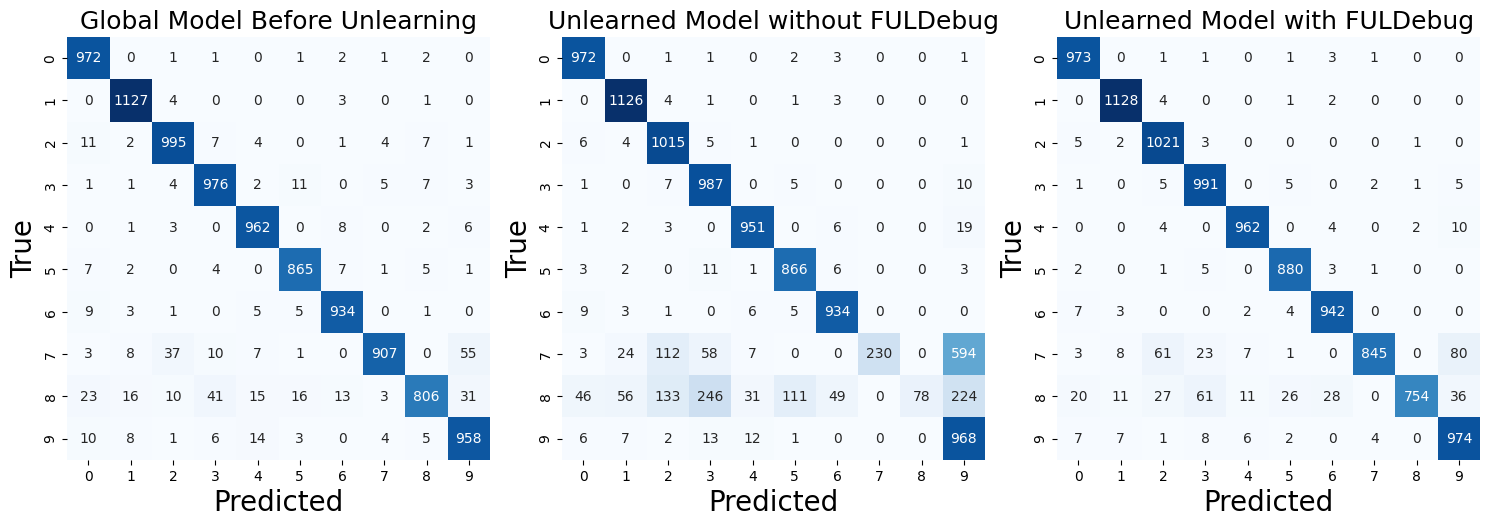

In [145]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# Assume these models are retrieved from your cache as in your snippet:
unlearned_model = cache.get('initial_model')
unlearned_model.load_state_dict(cache.get("unlearning_global_models"))
unlearned_model.eval()

unlearned_model_with_fuldebug = cache.get('initial_model')
unlearned_model_with_fuldebug.load_state_dict(cache.get("unlearning_global_models_with_FULDebug"))
unlearned_model_with_fuldebug.eval()

global_model_before = cache.get('initial_model')
global_model_before.load_state_dict(cache.get("global_models"))
global_model_before.eval()

client_model = cache.get('initial_model')
client_model.load_state_dict(cache.get("client_models")[0].state_dict())
client_model.eval()

# Prepare the test dataset (MNIST)
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

def evaluate_model(model, dataloader, device='cpu'):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Evaluate each model on the test dataset
labels_global, preds_global = evaluate_model(global_model_before, test_loader, device)
labels_unlearned, preds_unlearned = evaluate_model(unlearned_model, test_loader, device)
labels_unlearned_with_fuldebug, preds_unlearned_with_fuldebug = evaluate_model(unlearned_model_with_fuldebug, test_loader, device)
labels_client, preds_client = evaluate_model(client_model, test_loader, device)

# Calculate confusion matrices and accuracies
cm_global = confusion_matrix(labels_global, preds_global)
cm_unlearned_without_fuldebug = confusion_matrix(labels_unlearned, preds_unlearned)
cm_unlearned_with_fuldebug = confusion_matrix(labels_unlearned_with_fuldebug, preds_unlearned_with_fuldebug)
cm_client = confusion_matrix(labels_client, preds_client)

acc_global = accuracy_score(labels_global, preds_global)
acc_unlearned = accuracy_score(labels_unlearned, preds_unlearned)
acc_unlearned_with_fuldebug = accuracy_score(labels_unlearned_with_fuldebug, preds_unlearned_with_fuldebug)
acc_client = accuracy_score(labels_client, preds_client)

print(f"Global Model Before Unlearning Accuracy: {acc_global*100:.2f}%")
print(f"Unlearned Model Accuracy: {acc_unlearned*100:.2f}%")
print(f"Unlearned Model Accuracy with FulDebug: {acc_unlearned_with_fuldebug*100:.2f}%")
print(f"Client Model Accuracy: {acc_client*100:.2f}%")

# Plot confusion matrices side by side in equal-size subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Global Model Before Unlearning
sns.heatmap(cm_global, annot=True, fmt='d', cmap='Blues', ax=axes[0], square=True, cbar=False)
axes[0].set_title(f'Global Model Before Unlearning', fontsize=18)
axes[0].set_xlabel('Predicted', fontsize=20)
axes[0].set_ylabel('True', fontsize=20)

# Unlearned Model without FULDebug
sns.heatmap(cm_unlearned_without_fuldebug, annot=True, fmt='d', cmap='Blues', ax=axes[1], square=True, cbar=False)
axes[1].set_title(f'Unlearned Model without FULDebug', fontsize=18)
axes[1].set_xlabel('Predicted', fontsize=20)
axes[1].set_ylabel('True', fontsize=20)

# Unlearned Model with FULDebug
sns.heatmap(cm_unlearned_with_fuldebug, annot=True, fmt='d', cmap='Blues', ax=axes[2], square=True, cbar=False)
axes[2].set_title(f'Unlearned Model with FULDebug', fontsize=18)
axes[2].set_xlabel('Predicted', fontsize=20)
axes[2].set_ylabel('True', fontsize=20)

# Client Model
# sns.heatmap(cm_client, annot=True, fmt='d', cmap='Blues', ax=axes[3], square=True, cbar=False)
# axes[3].set_title(f'Unlearned Client Model', fontsize=18)
# axes[3].set_xlabel('Predicted', fontsize=20)
# axes[3].set_ylabel('True', fontsize=20)

plt.tight_layout()
plt.savefig('mnist-10-ibmful')
plt.show()


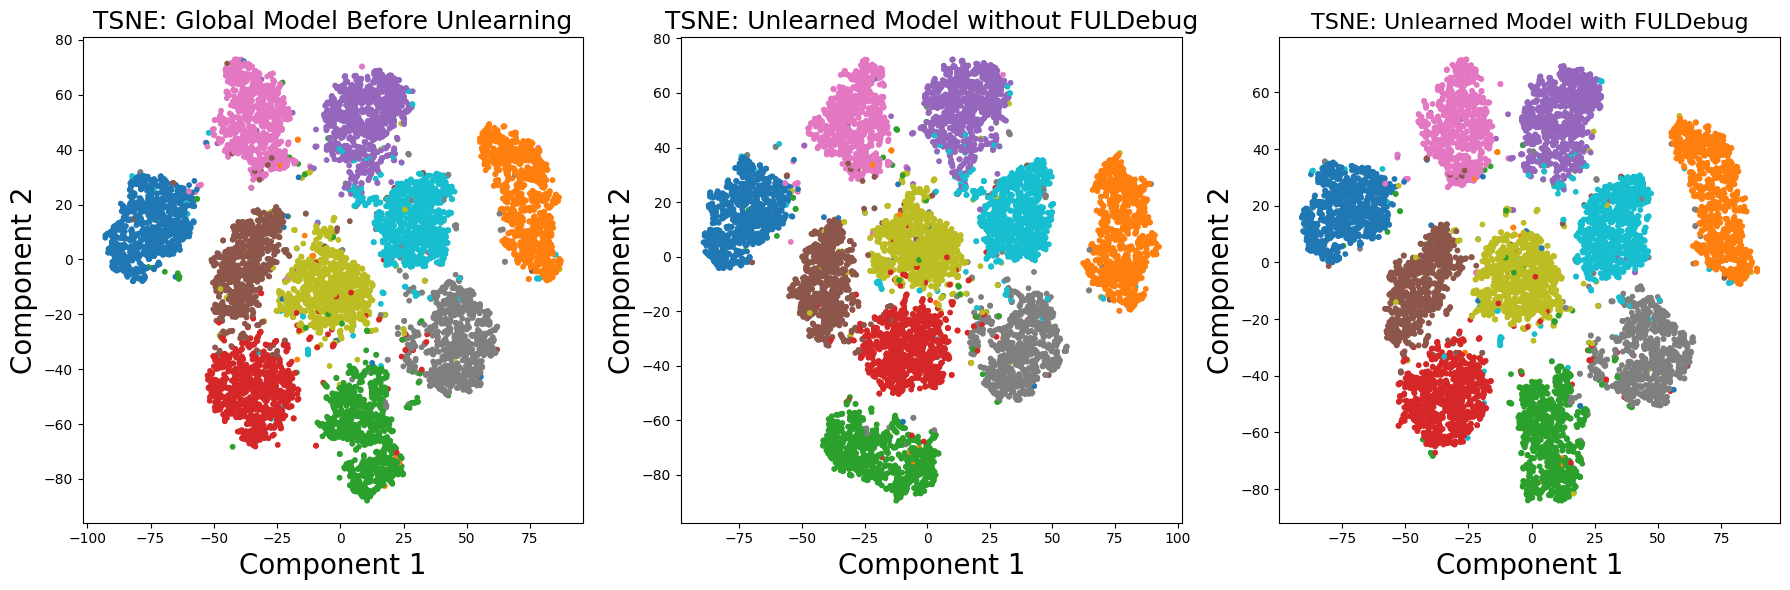

In [143]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# Retrieve models from cache
unlearned_model = cache.get('initial_model')
unlearned_model.load_state_dict(cache.get("unlearning_global_models"))
unlearned_model.eval()

unlearned_model_with_fuldebug = cache.get('initial_model')
unlearned_model_with_fuldebug.load_state_dict(cache.get("unlearning_global_models_with_FULDebug"))
unlearned_model_with_fuldebug.eval()

global_model_before = cache.get('initial_model')
global_model_before.load_state_dict(cache.get("global_models"))
global_model_before.eval()

# Use the test dataset (e.g., MNIST)
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

def get_embeddings(model, dataloader, device='cpu', layer_name='fc1'):
    """
    Extract embeddings from a given layer of the model using a forward hook.
    The layer name 'fc1' should be replaced with the appropriate layer in your model.
    Returns concatenated embeddings and labels.
    """
    embeddings = []
    all_labels = []
    
    # Define the hook function that saves the output of the specified layer.
    def hook_fn(module, input, output):
        embeddings.append(output.cpu().detach().numpy())
    
    # Register hook; adjust the attribute name as per your model architecture.
    handle = getattr(model, layer_name).register_forward_hook(hook_fn)
    
    model.to(device)
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            _ = model(images)
            all_labels.extend(labels.numpy())
    
    # Remove hook and concatenate embeddings
    handle.remove()
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings, np.array(all_labels)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Extract embeddings for each model.
emb_global, labels_global = get_embeddings(global_model_before, test_loader, device, layer_name='fc1')
emb_unlearned, _ = get_embeddings(unlearned_model, test_loader, device, layer_name='fc1')
emb_fuldebug, _ = get_embeddings(unlearned_model_with_fuldebug, test_loader, device, layer_name='fc1')

# Use TSNE to reduce dimensionality to 2D.
tsne = TSNE(n_components=2, random_state=42)
tsne_global = tsne.fit_transform(emb_global)
tsne_unlearned = tsne.fit_transform(emb_unlearned)
tsne_fuldebug = tsne.fit_transform(emb_fuldebug)

# Plot TSNE scatter plots for the three models.
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].scatter(tsne_global[:, 0], tsne_global[:, 1], c=labels_global, cmap='tab10', s=10)
axes[0].set_title('TSNE: Global Model Before Unlearning', fontsize=18)
axes[0].set_xlabel('Component 1', fontsize=20)
axes[0].set_ylabel('Component 2', fontsize=20)

axes[1].scatter(tsne_unlearned[:, 0], tsne_unlearned[:, 1], c=labels_global, cmap='tab10', s=10)
axes[1].set_title('TSNE: Unlearned Model without FULDebug', fontsize=18)
axes[1].set_xlabel('Component 1', fontsize=20)
axes[1].set_ylabel('Component 2', fontsize=20)

axes[2].scatter(tsne_fuldebug[:, 0], tsne_fuldebug[:, 1], c=labels_global, cmap='tab10', s=10)
axes[2].set_title('TSNE: Unlearned Model with FULDebug', fontsize=16)
axes[2].set_xlabel('Component 1', fontsize=20)
axes[2].set_ylabel('Component 2', fontsize=20)

plt.tight_layout()
plt.show()
